In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import csv
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
dataset = pd.read_csv("dataset_with_labels.csv")
dataset = dataset[0:102]
col = ['Label', 'Review']
dataset = dataset[col]
dataset = dataset[pd.notnull(dataset['Review'])]
dataset.shape
ll = []
for s in dataset['Label']:
    l = s.split(",")
    ll.append(l)
dataset['Label'] = ll

In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [4]:
dataset['Review'] = dataset['Review'].apply(clean_text)
dataset['Review'] = dataset['Review'].apply(stemming)
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit_transform(dataset['Label'])
y = multilabel_binarizer.transform(dataset['Label'])
for idx, label in enumerate(multilabel_binarizer.classes_):
    print(label)
    dataset[label] = y[:,idx]
dataset.to_csv('dataset_new.csv')
dataset_new = pd.read_csv('dataset_new.csv')
dataset = dataset_new

Compatibility Issue
Feature Request
Functional Complaint
Network Problem
Resource Heavy
Uninteresting Comment
Update Issue
User Interface


In [5]:
train, test = train_test_split(dataset, random_state=42, test_size=0.3, shuffle=True)
train_text = train['Review'].values.astype('U')
test_text = test['Review'].values.astype('U')
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2', max_features=10000)
vectorizer.fit(train_text)
vectorizer.fit(test_text)
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels=['Unnamed: 0', 'Label', 'Review'], axis=1)
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels=['Unnamed: 0', 'Label', 'Review'], axis=1)

## Binary Relevance

In [6]:
br_classifier = BinaryRelevance(classifier=GaussianNB())
br_classifier.fit(x_train, y_train)
br_predictions = br_classifier.predict(x_test)
print(br_predictions)
print("Accuracy = ",accuracy_score(y_test,br_predictions.toarray()))

  (3, 1)	1
  (1, 2)	1
  (2, 2)	1
  (4, 2)	1
  (8, 2)	1
  (9, 2)	1
  (10, 2)	1
  (12, 2)	1
  (14, 2)	1
  (18, 2)	1
  (19, 2)	1
  (20, 2)	1
  (22, 2)	1
  (23, 2)	1
  (24, 2)	1
  (26, 2)	1
  (27, 2)	1
  (29, 2)	1
  (30, 2)	1
  (13, 5)	1
  (21, 5)	1
  (5, 6)	1
  (11, 6)	1
  (17, 6)	1
  (22, 6)	1
Accuracy =  0.2903225806451613


## Label Powerset

In [7]:
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(x_train, y_train)
lp_predictions = lp_classifier.predict(x_test)
print(lp_predictions)
print("Accuracy = ",accuracy_score(y_test,lp_predictions))
print("F1 score = ",f1_score(y_test,lp_predictions, average="micro"))
print("Hamming loss = ",hamming_loss(y_test,lp_predictions))

F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


  (0, 2)	1
  (1, 2)	1
  (2, 2)	1
  (3, 2)	1
  (4, 2)	1
  (5, 2)	1
  (6, 2)	1
  (7, 2)	1
  (8, 2)	1
  (9, 2)	1
  (10, 2)	1
  (11, 2)	1
  (12, 2)	1
  (13, 2)	1
  (14, 2)	1
  (15, 2)	1
  (16, 2)	1
  (17, 2)	1
  (18, 2)	1
  (19, 2)	1
  (20, 2)	1
  (21, 2)	1
  (22, 2)	1
  (23, 2)	1
  (24, 2)	1
  (25, 2)	1
  (26, 2)	1
  (27, 2)	1
  (28, 2)	1
  (29, 2)	1
  (30, 2)	1
Accuracy =  0.3548387096774194
F1 score =  0.4
Hamming loss =  0.1693548387096774


## MLkNN

In [8]:
#MLkNN
ml_classifier = MLkNN(k=10)
# to prevent errors when handling sparse matrices.
x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()
ml_classifier.fit(x_train, y_train)
# predict
ml_predictions = ml_classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,ml_predictions))

Accuracy =  0.12903225806451613


F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda3\lib\site-packages

  (0, 0)	0.09509230509704249
  (1, 0)	0.09328841514850814
  (2, 0)	0.09249497237969505
  (3, 0)	0.1003951719769307
  (4, 0)	0.09356438239190208
  (5, 0)	0.08515171965736988
  (6, 0)	0.08990819793797733
  (7, 0)	0.09703722475565048
  (8, 0)	0.09262239199827486
  (9, 0)	0.09305982050463302
  (10, 0)	0.0993094982868835
  (11, 0)	0.09352195764914147
  (12, 0)	0.09431563495009579
  (13, 0)	0.09839949000538448
  (14, 0)	0.09468891834362507
  (15, 0)	0.0924646747967764
  (16, 0)	0.0962882068608605
  (17, 0)	0.09081237790239931
  (18, 0)	0.10228676619101862
  (19, 0)	0.10093385919132099
  (20, 0)	0.08776347837073926
  (21, 0)	0.09067707869498451
  (22, 0)	0.09580867140986632
  (23, 0)	0.09105550167971573
  (24, 0)	0.08973269416922627
  :	:
  (6, 6)	0.2191182895692224
  (7, 6)	0.14402071231641342
  (8, 6)	0.13533841102976538
  (9, 6)	0.11519196120227065
  (10, 6)	0.10617104685650096
  (11, 6)	0.10320742707814484
  (12, 6)	0.10468364250013458
  (13, 6)	0.21576700202240187
  (14, 6)	0.11066238768

F:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 =  0.0
Hamming loss =  0.17511520737327188
t = 0.59
Accuracy =  0.03225806451612903
F1 =  0.0
Hamming loss =  0.17511520737327188


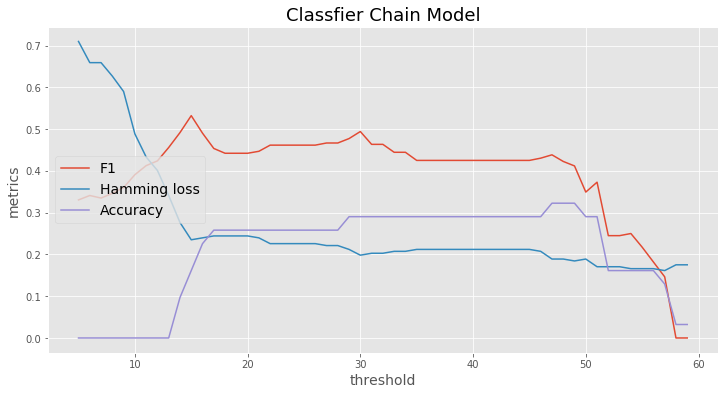

In [9]:
y_train = train.drop(labels = ['Unnamed: 0', 'Label', 'Review'], axis=1)
selected_labels = y_train.columns[y_train.sum(axis = 0, skipna = True) > 0].tolist()
y_test = test.drop(labels = ['Unnamed: 0', 'Label', 'Review'], axis=1)
y_train = y_train.filter(selected_labels, axis=1)
y_test = y_test.filter(selected_labels, axis=1)
x_train = vectorizer.transform(train_text)
x_test = vectorizer.transform(test_text)
cc_classifier = ClassifierChain(LogisticRegression(solver='warn'))
cc_classifier.fit(x_train, y_train)
cc_predictions_proba = cc_classifier.predict_proba(x_test)
print(cc_predictions_proba)
#for plotting metrics as a function of threashold
th = []
f = []
ham = []
ac = []
for t in range (5,60): # threshold value
    y_pred_new = (cc_predictions_proba >= t/100).astype(int)
    print("t =" ,t/100)
    print("Accuracy = ",accuracy_score(y_test,y_pred_new))
    print("F1 = ",f1_score(y_test,y_pred_new, average="micro"))
    print("Hamming loss = ",hamming_loss(y_test,y_pred_new))
    th.append(t)
    ac.append(accuracy_score(y_test,y_pred_new))
    f.append(f1_score(y_test,y_pred_new, average="micro"))
    ham.append(hamming_loss(y_test,y_pred_new))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, ham)
    plt.plot(th, ac)
    plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
    plt.ylabel("metrics", fontsize = 14)
    plt.xlabel("threshold", fontsize = 14)
    plt.title("Classfier Chain Model", fontsize = 18)
    plt.show()

In [10]:
t = 47
y_pred_new = (cc_predictions_proba >= t/100).astype(int)
print(y_pred_new)

  (0, 2)	1
  (1, 2)	1
  (2, 2)	1
  (3, 2)	1
  (4, 2)	1
  (6, 2)	1
  (7, 2)	1
  (8, 2)	1
  (9, 2)	1
  (10, 2)	1
  (11, 2)	1
  (12, 2)	1
  (13, 2)	1
  (14, 2)	1
  (15, 2)	1
  (16, 2)	1
  (17, 2)	1
  (18, 2)	1
  (19, 2)	1
  (20, 2)	1
  (21, 2)	1
  (22, 2)	1
  (23, 2)	1
  (24, 2)	1
  (26, 2)	1
  (27, 2)	1
  (29, 2)	1
  (30, 2)	1
  (0, 5)	1
  (5, 5)	1
  (7, 5)	1
  (15, 5)	1
  (17, 5)	1
  (18, 5)	1
  (28, 5)	1
